In [1]:
import numpy as np
import lbg_forecast.nz as nz
import lbg_forecast.population_model as pop
import lbg_forecast.nz as nz
import matplotlib.pyplot as plt
import lbg_forecast.sfh as sfh
import lbg_forecast.priors_gp_dust as gpdp
import scipy as sc

In [2]:
nruns=1
run='test'
extra=True
spsp = []
selected_spsp = []
photometry = []
nzs = []
trans_cut = []
trans = []
for i in range(nruns):
    spsp.append(np.load("sps_parameter_samples/sps_"+run+"_"+str(i)+".npy"))
    selected_spsp.append(np.load("sps_parameter_samples/selected_sps_"+run+"_"+str(i)+".npy", allow_pickle=True))
    photometry.append(np.load("photo_samples/photo_"+run+"_"+str(i)+".npy"))
    nzs.append(np.load("nz_samples/nz_"+run+"_"+str(i)+".npy", allow_pickle=True))
    trans_cut.append(np.load("nz_samples/trans_cut_"+run+"_"+str(i)+".npy"))
    trans.append(np.load("nz_samples/trans_"+run+"_"+str(i)+".npy"))

spsp = np.vstack(spsp)
selected_spsp = np.vstack(selected_spsp)
photometry = np.vstack(photometry)
nzs = np.vstack(nzs)
trans_cut = np.vstack(trans_cut)
trans = np.vstack(trans)
print(spsp.shape, selected_spsp.shape, photometry.shape, nzs.shape, trans_cut.shape, trans.shape)

(8, 200000, 17) (8, 3) (8, 200000, 5) (8, 3) (8, 3) (8, 3)


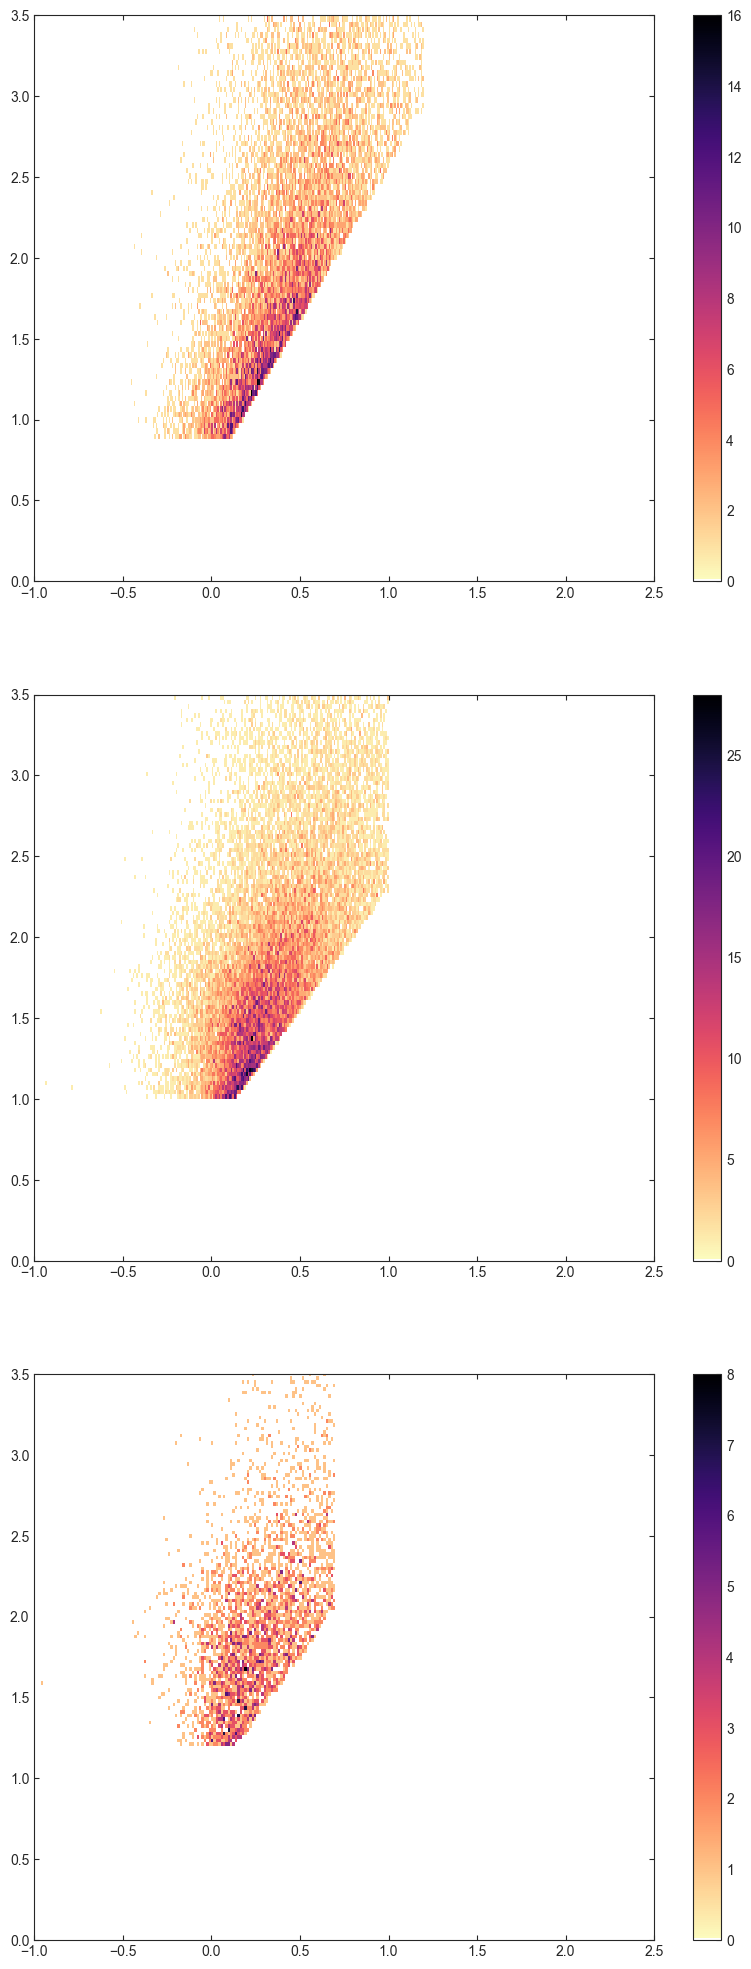

In [3]:
run_no=0
if(extra):

    from matplotlib.colors import LinearSegmentedColormap
    magma = plt.get_cmap('magma_r')
    rgba = magma(np.linspace(0, 1, 256))
    rgba[0] = [1, 1, 1, 1]
    magma_whitebackground = LinearSegmentedColormap.from_list('magma_white', rgba)

    f, ax = plt.subplots(3, 1, figsize=(10, 25))
    lbg_colours = np.load("nz_samples/c_"+run+"_"+str(run_no)+".npy", allow_pickle=True)
    for i in range(3):
        cs = []
        for real in lbg_colours[:, i]:
            cs.append(np.squeeze(real))

        dropout_colours = np.vstack(cs)
        histogram = ax[i].hist2d(dropout_colours[:, i+1], dropout_colours[:, i], alpha=1.0, bins=(200,400), cmap=magma_whitebackground, density=False)
        f.colorbar(histogram[-1], orientation='vertical')
        ax[i].set_ylim(0, 3.5)
        ax[i].set_xlim(-1, 2.5)


In [4]:
percentile=84
mean = np.mean(trans_cut, axis=0)
std =  3*np.std(trans_cut, axis=0)
errl = np.percentile(trans_cut, 100-percentile, axis=0)
errh = np.percentile(trans_cut, percentile, axis=0)

print("u-dropout number density (cut): ",mean[0],"-",(mean-errl)[0],"+",(errh-mean)[0],"deg-2")
print("g-dropout number density (cut): ",mean[1],"-",(mean-errl)[1],"+",(errh-mean)[1],"deg-2")
print("r-dropout number density (cut): ",mean[2],"-",(mean-errl)[2],"+",(errh-mean)[2],"deg-2")



mean = np.mean(trans, axis=0)
std =  3*np.std(trans, axis=0)
errl = np.percentile(trans, 100-percentile, axis=0)
errh = np.percentile(trans, percentile, axis=0)

print("u-dropout number density: ",mean[0],"-",(mean-errl)[0],"+",(errh-mean)[0],"deg-2")
print("g-dropout number density: ",mean[1],"-",(mean-errl)[1],"+",(errh-mean)[1],"deg-2")
print("r-dropout number density: ",mean[2],"-",(mean-errl)[2],"+",(errh-mean)[2],"deg-2")

u-dropout number density (cut):  8681.734637557003 - 523.9219238734468 + 564.23364002171 deg-2
g-dropout number density (cut):  14621.60117100953 - 915.5743212827147 + 1138.4743509005748 deg-2
r-dropout number density (cut):  2312.3730589014654 - 391.3254050637231 + 371.0148730751648 deg-2
u-dropout number density:  33878.450626931124 - 5239.758879296995 + 694.8433891624009 deg-2
g-dropout number density:  57652.80749609109 - 8519.516785947548 + 1322.8576936101817 deg-2
r-dropout number density:  9397.215424283593 - 2504.7281865434625 + 667.6234902882697 deg-2


In [5]:
def plot_nzs(axes, nzs, mean, density, a, p, **kwargs):

    ndropouts = 3

    percentile=p

    bin_step = 0.2
    bin_start = 0
    bin_end = 7

    bins = np.arange(bin_start, bin_end, bin_step)
    colours = ['blue', 'green', 'red']
    labels = ['$u$-dropouts', "$g$-dropouts", "$r$-dropouts"]
    lss=['--', '-.', '-']


    samples=50
    grid = np.arange(bin_start, bin_end-bin_step, bin_step/samples)

    for drop in range(ndropouts):

        values = []
        for ind in range(nzs.shape[0]):
            hist = np.histogram(nzs[ind][drop], density=density, bins=bins)
            oversampled_values = np.repeat(hist[0], samples)
            values.append(oversampled_values)

        values = np.vstack((np.array(values)))
        mean_at_grid_point = np.mean(values, axis=0)
        percentile_at_point = np.percentile(values, [100-percentile, 50, percentile], axis=0)
        if(mean):
            axes.plot(grid, mean_at_grid_point, c=colours[drop], **kwargs, label=labels[drop], ls=lss[drop], lw=2)
        axes.fill_between(grid, percentile_at_point[0, :], percentile_at_point[2, :], alpha=a, color=colours[drop], lw=0)

    axes.legend(fontsize=18, ncol=3, loc='upper left')
    axes.set_xlabel("Redshift $z$", fontsize=24)
    axes.set_ylabel("$p$($z$|Dropout Selection, SPS Model)", fontsize=24)
    axes.set_xticks(np.arange(0, 7, 0.5))
    axes.tick_params('x', labelsize=24)
    axes.tick_params('y', labelsize=24)
    axes.grid(alpha=0.2)
    axes.set_xlim(0, 6)
    axes.set_ylim(0, 1.8)

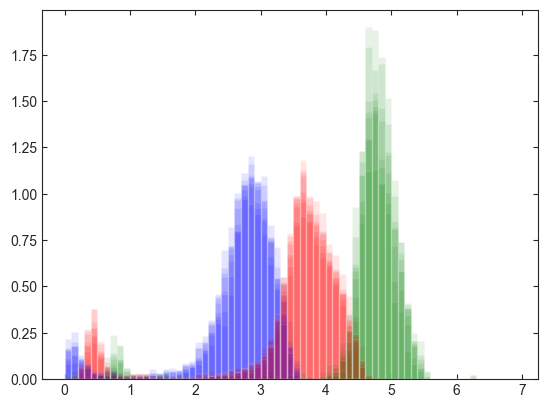

In [6]:
bins = nz.default_nz_bins()

for n in range(nzs.shape[0]):
    hist = plt.hist(nzs[n][0], density=True, bins=bins, alpha = 0.1, color='blue')
    hist = plt.hist(nzs[n][1], density=True, bins=bins, alpha = 0.1, color='red')
    hist = plt.hist(nzs[n][2], density=True, bins=bins, alpha = 0.1, color='green')

In [7]:
def get_mass_less_8(seleced_sps, real):

    umasses = np.log10(np.squeeze(seleced_sps[real, 0])[:, -1])
    gmasses = np.log10(np.squeeze(seleced_sps[real, 1])[:, -1])
    rmasses = np.log10(np.squeeze(seleced_sps[real, 2])[:, -1])

    umasses8 = umasses[np.where(umasses < 8)[0]]
    gmasses8 = gmasses[np.where(gmasses < 8)[0]]
    rmasses8 = rmasses[np.where(rmasses < 8)[0]]

    upless8 = (len(umasses8)/len(umasses))*100
    gpless8 = (len(gmasses8)/len(gmasses))*100
    rpless8 = (len(rmasses8)/len(rmasses))*100

    return upless8, gpless8, rpless8

per_mass = np.zeros(3)
for indx in range(nzs.shape[0]):
    per_mass+=np.array(get_mass_less_8(selected_spsp, indx))

per_mass/nzs.shape[0]

array([3.19011954, 2.99971366, 0.65528761])

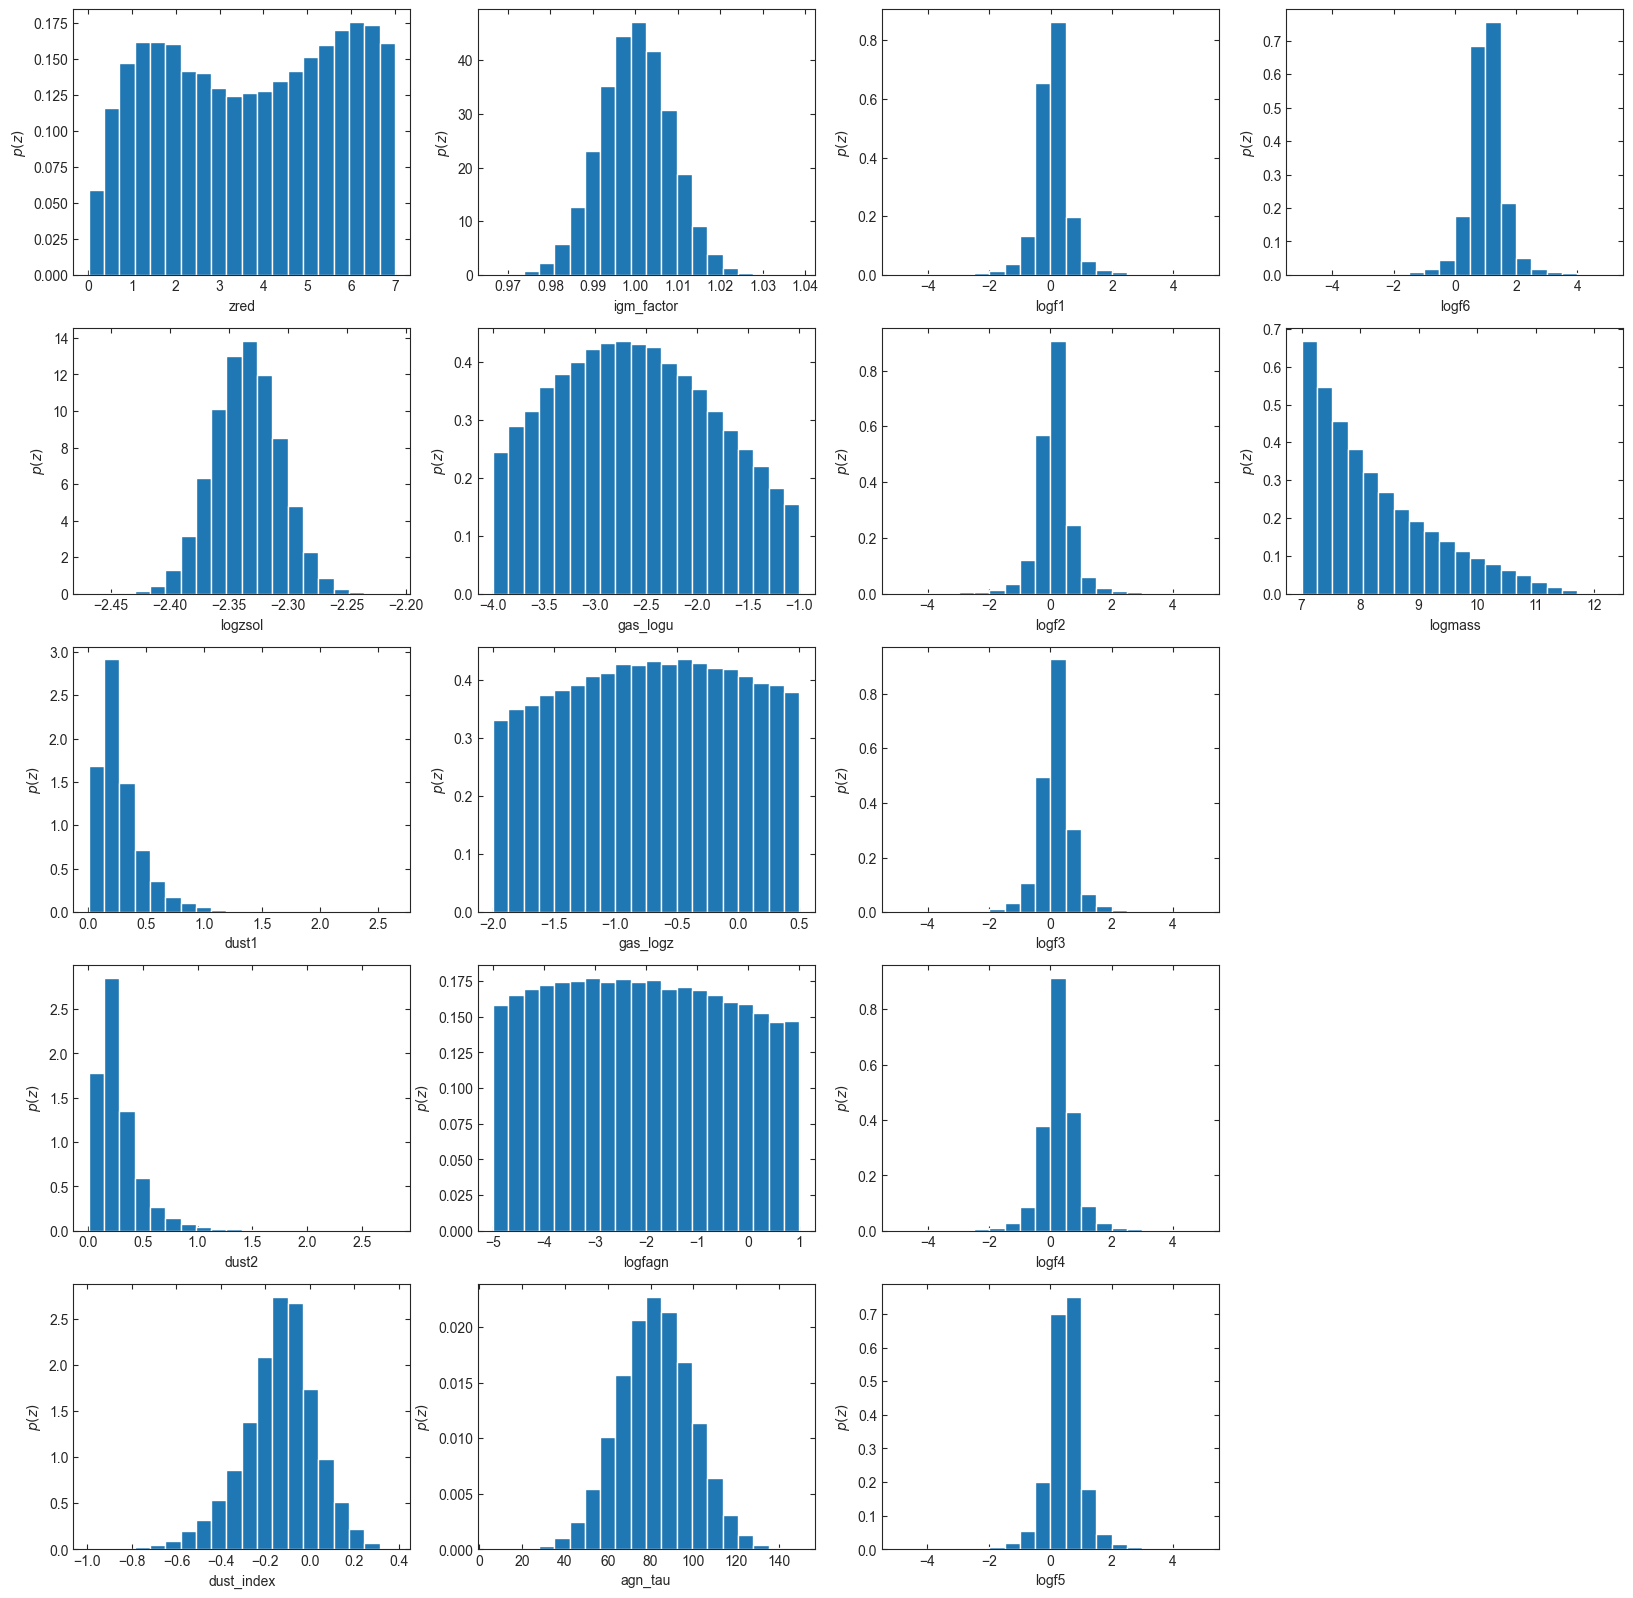

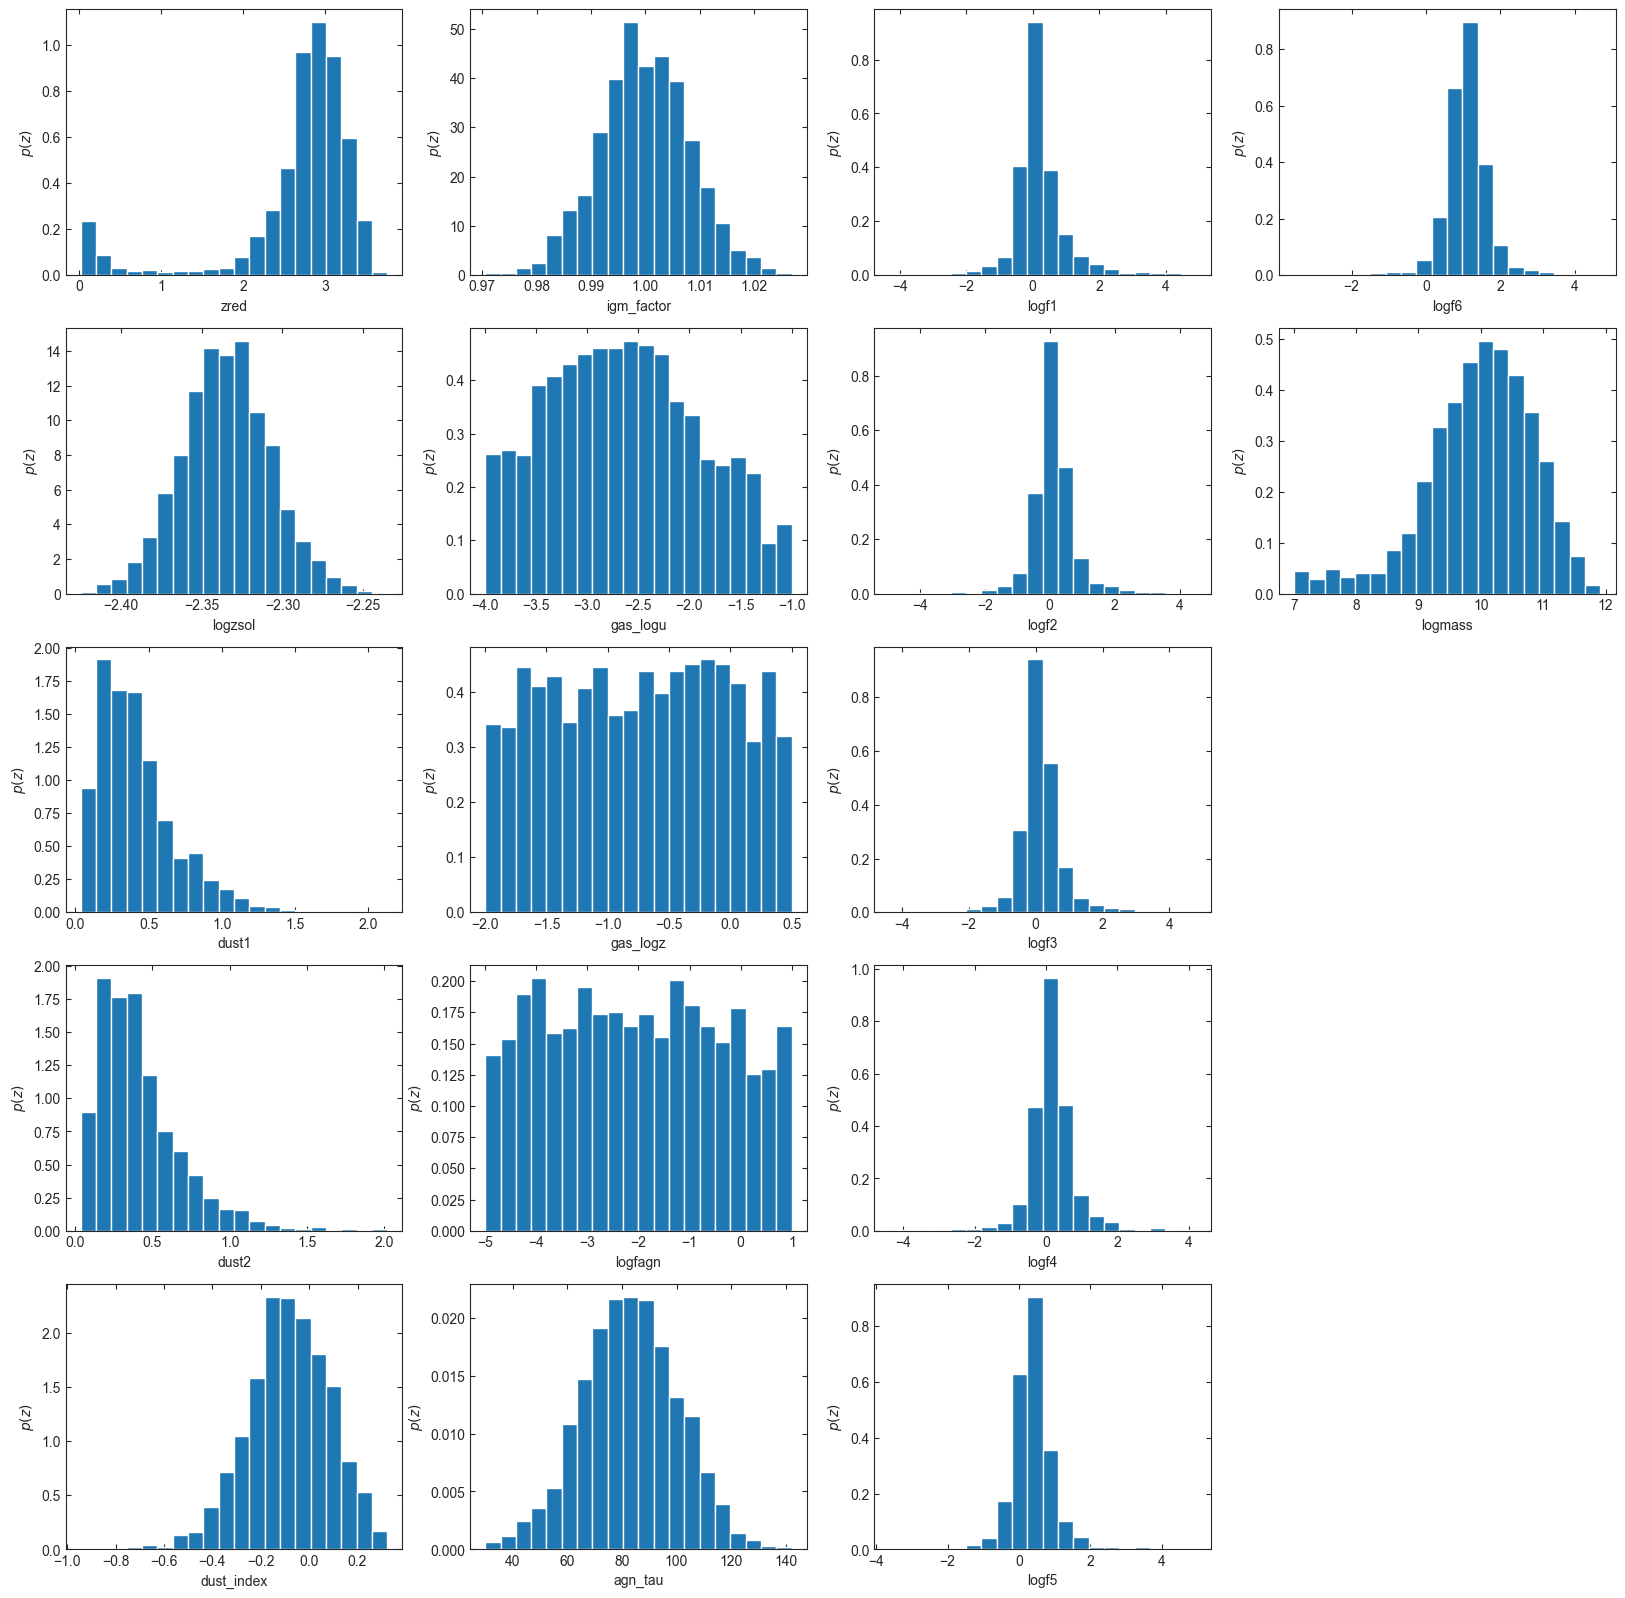

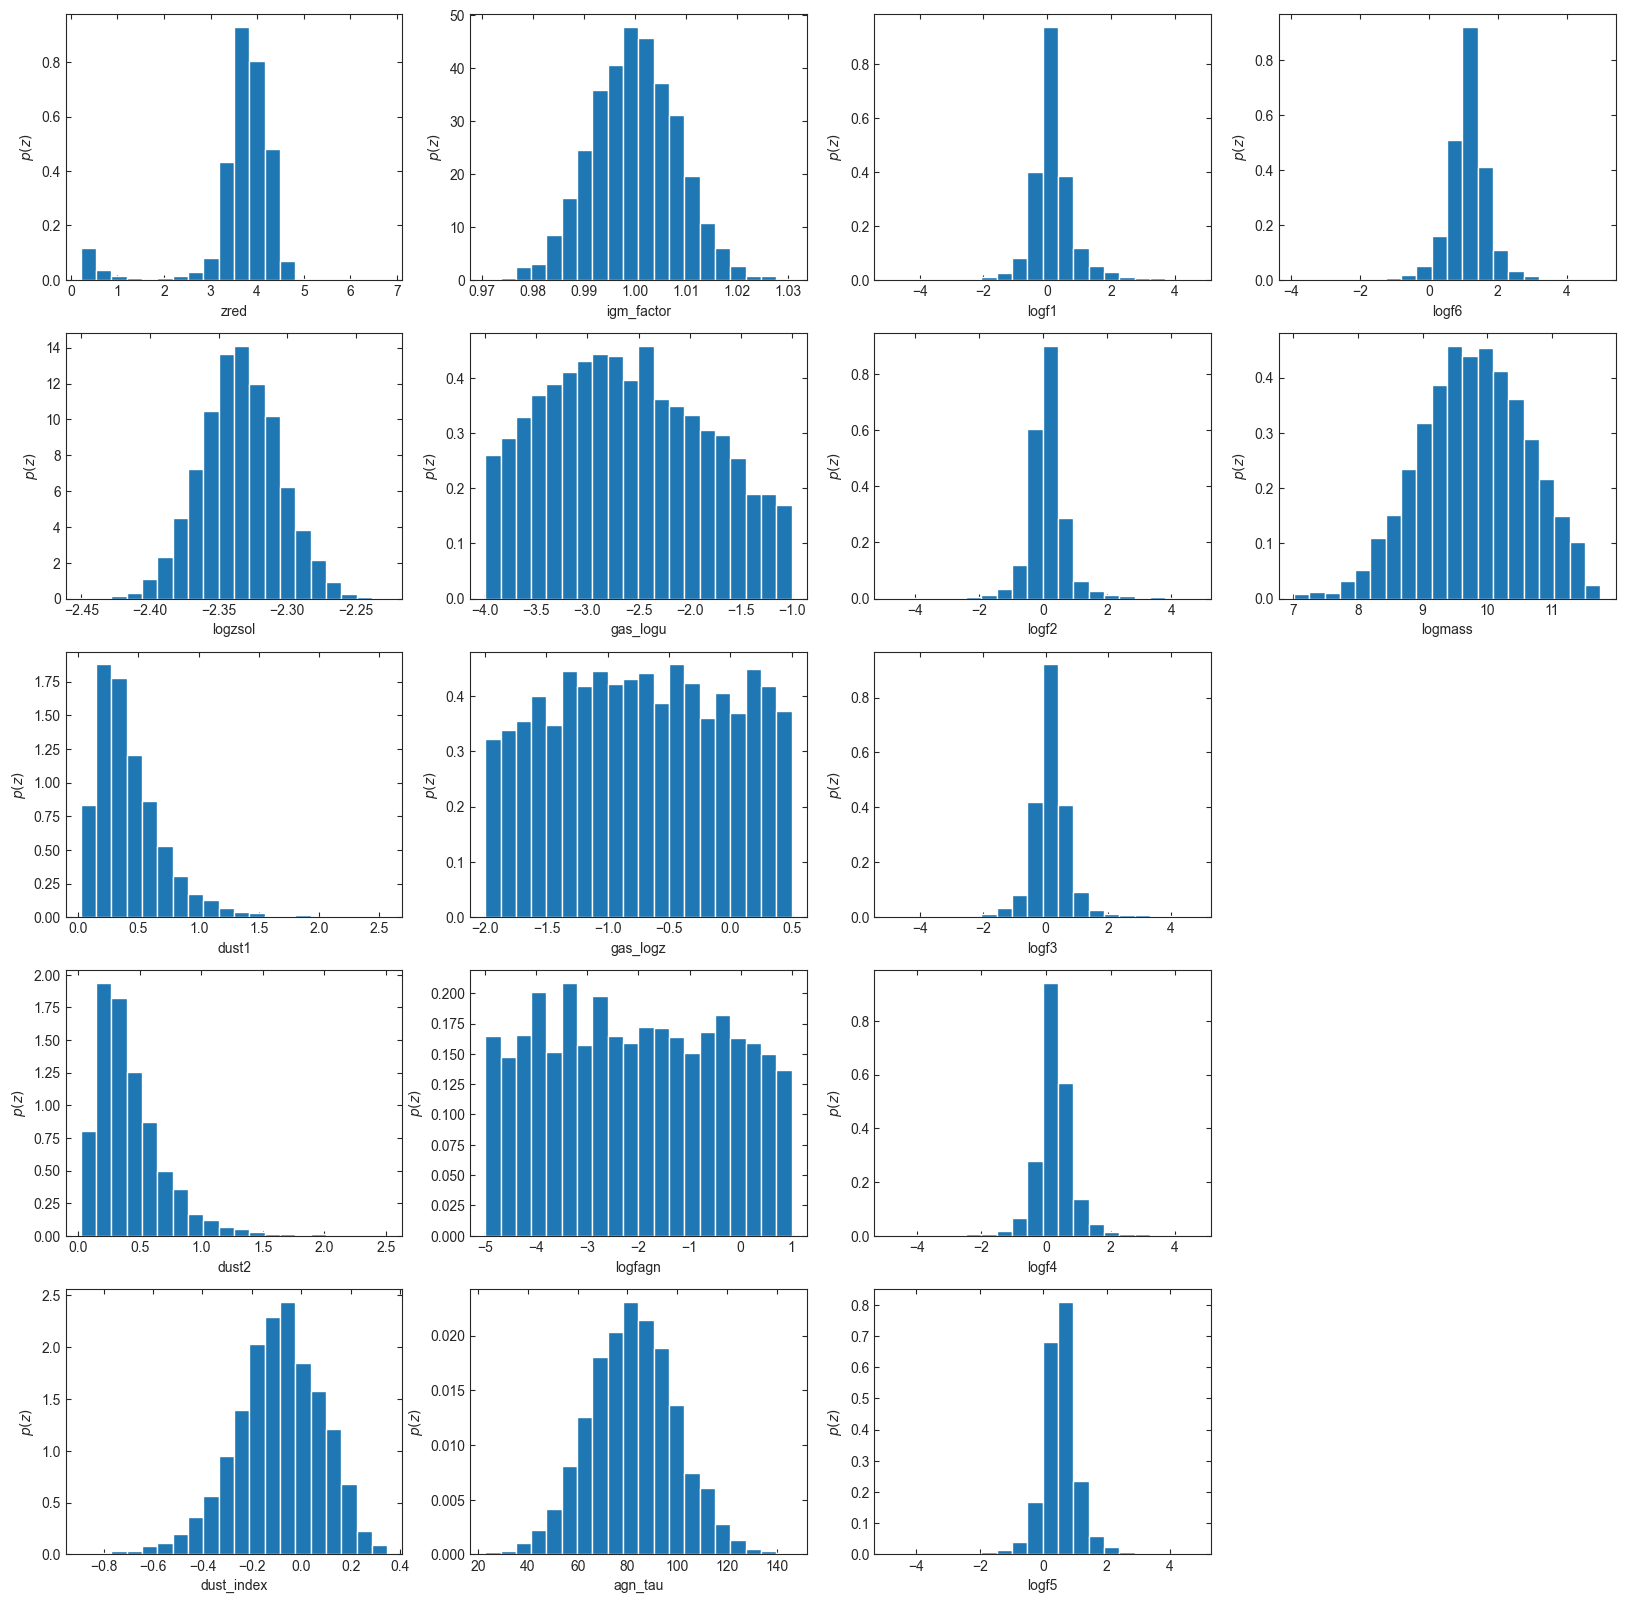

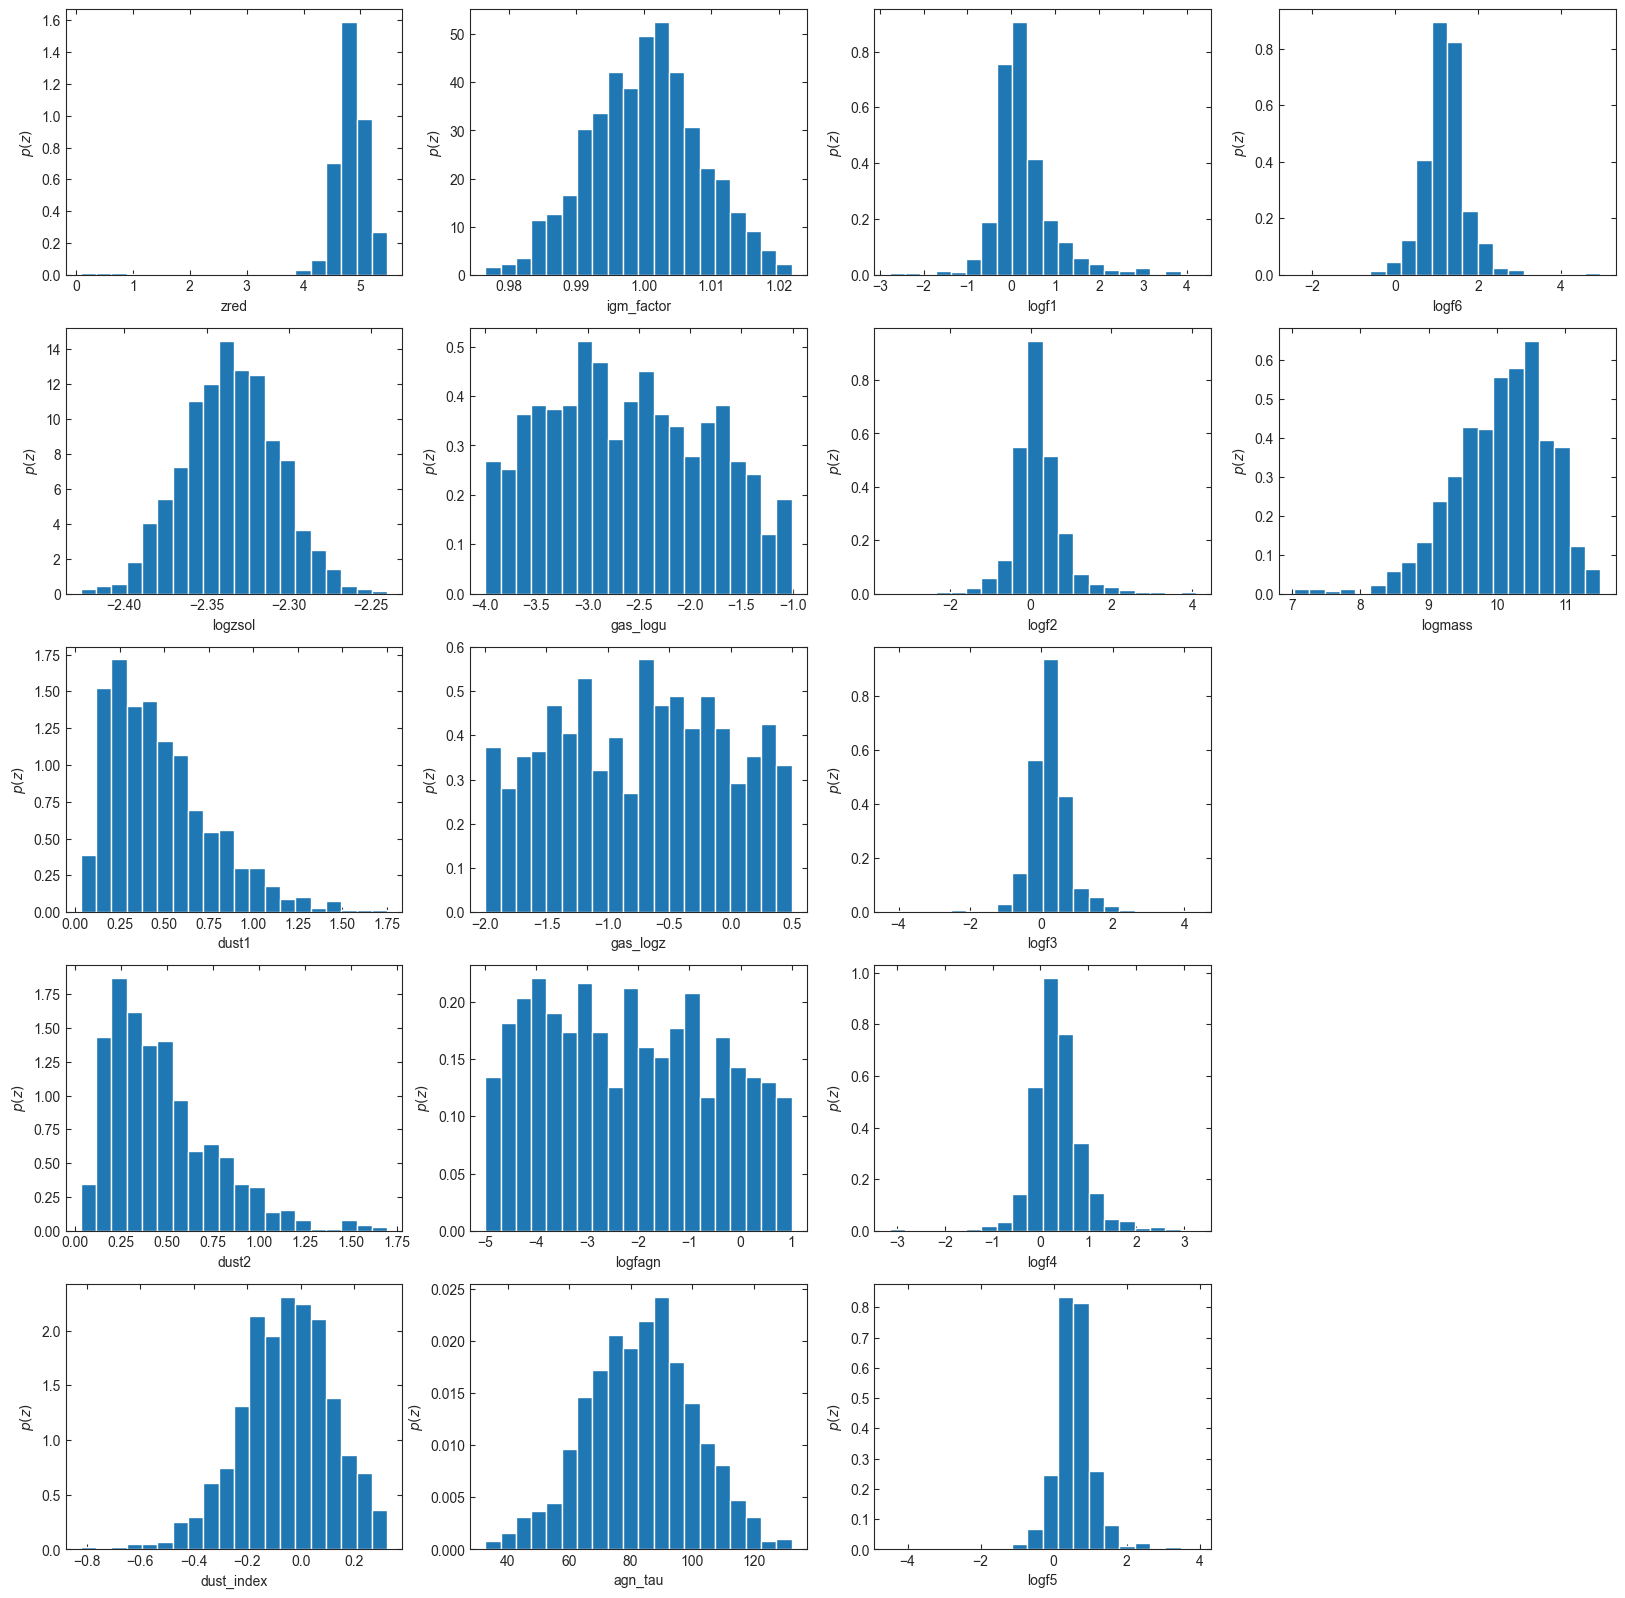

In [8]:
indx=np.random.randint(0, nzs.shape[0])
pop.plot_galaxy_population(spsp[indx])
pop.plot_galaxy_population(np.squeeze(selected_spsp[indx, 0]))
pop.plot_galaxy_population(np.squeeze(selected_spsp[indx, 1]))
pop.plot_galaxy_population(np.squeeze(selected_spsp[indx, 2]))

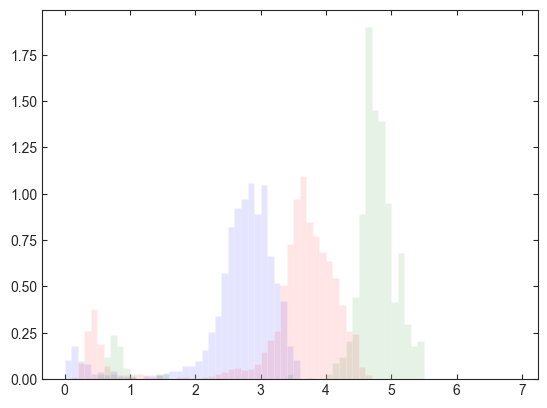

In [9]:
indx=np.random.randint(0, nzs.shape[0])
hist = plt.hist(nzs[indx][0], density=True, bins=bins, alpha = 0.1, color='blue')
hist = plt.hist(nzs[indx][1], density=True, bins=bins, alpha = 0.1, color='red')
hist = plt.hist(nzs[indx][2], density=True, bins=bins, alpha = 0.1, color='green')

u-dropout Interloper Fraction: 7.417065491149183 +/- 0.7175878688079337
g-dropout Interloper Fraction: 9.192393211066925 +/- 1.8957192747626381
r-dropout Interloper Fraction: 3.3229403497984835 +/- 1.6406419013473266


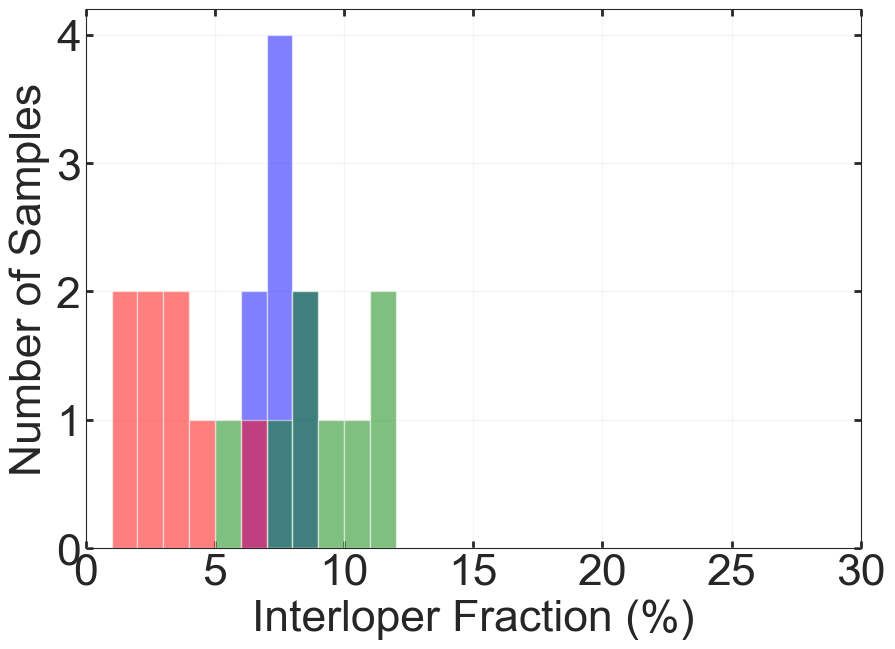

In [10]:
def interlopers(samples):
    nint = len(np.where(samples<1.5)[0])
    ntot = len(samples)
    return (nint/ntot)*100

f, ax = plt.subplots(1, 1, figsize=(10, 7))

uints = []
gints = []
rints = []
for n in range(nzs.shape[0]):
    uints.append(interlopers(nzs[n][0]))
    gints.append(interlopers(nzs[n][1]))
    rints.append(interlopers(nzs[n][2]))

nbins = np.arange(0.0, 100, 1)
histogram = ax.hist(uints, alpha=0.5, bins=nbins, color='blue')
histogram = ax.hist(gints, alpha=0.5, bins=nbins, color='green')
histogram = ax.hist(rints, alpha=0.5, bins=nbins, color='red')

uints_mean = np.mean(uints)
uints_std = np.std(uints)
gints_mean = np.mean(gints)
gints_std = np.std(gints)
rints_mean = np.mean(rints)
rints_std = np.std(rints)

print("u-dropout Interloper Fraction:", uints_mean,"+/-",uints_std)
print("g-dropout Interloper Fraction:", gints_mean,"+/-",gints_std)
print("r-dropout Interloper Fraction:", rints_mean,"+/-",rints_std)

ax.set_xticks(np.arange(0, 35, 5))

ax.set_xlim(0, 30)
ax.grid(alpha=0.2)
ax.set_xlabel("Interloper Fraction (%)", fontsize=32)
ax.set_ylabel("Number of Samples", fontsize=32)
ax.tick_params('x', labelsize=32, width=2, size=5, direction='in', top=True)
ax.tick_params('y', labelsize=32, width=2, size=5, direction='in', right=True)

In [11]:
#np.save("redshifts/emulated_redshifts_0.npy", nzs)

In [12]:
#np.save("nzs_test2.npy", nzs)
#np.save("spsp_test2.npy", spsp)